In [2]:
# Copyright (c) 2024，WuChao D-Robotics.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import cv2
import numpy as np
from scipy.special import softmax
# from scipy.special import expit as sigmoid
from time import time
from bpu_infer_lib import Infer as bpu

In [3]:
coco_names = [
    "person", "bicycle", "car", "motorcycle", "airplane", 
    "bus", "train", "truck", "boat", "traffic light", 
    "fire hydrant", "stop sign", "parking meter", "bench", "bird", 
    "cat", "dog", "horse", "sheep", "cow", 
    "elephant", "bear", "zebra", "giraffe", "backpack", 
    "umbrella", "handbag", "tie", "suitcase", "frisbee", 
    "skis", "snowboard", "sports ball", "kite", "baseball bat", 
    "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", 
    "wine glass", "cup", "fork", "knife", "spoon", 
    "bowl", "banana", "apple", "sandwich", "orange", 
    "broccoli", "carrot", "hot dog", "pizza", "donut", 
    "cake", "chair", "couch", "potted plant", "bed", 
    "dining table", "toilet", "tv", "laptop", "mouse", 
    "remote", "keyboard", "cell phone", "microwave", "oven", 
    "toaster", "sink", "refrigerator", "book", "clock", 
    "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
    ]

yolo_colors = [
    (56, 56, 255), (151, 157, 255), (31, 112, 255), (29, 178, 255),
    (49, 210, 207), (10, 249, 72), (23, 204, 146), (134, 219, 61),
    (52, 147, 26), (187, 212, 0), (168, 153, 44), (255, 194, 0),
    (147, 69, 52), (255, 115, 100), (236, 24, 0), (255, 56, 132),
    (133, 0, 82), (255, 56, 203), (200, 149, 255), (199, 55, 255)]

def draw_detection(img: np.array, 
                   box: tuple, 
                   score: float, 
                   class_id: int):
    x1, y1, x2, y2 = box
    color = yolo_colors[class_id%20]
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    label = f"{coco_names[class_id]}: {score:.2f}"
    (label_width, label_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    label_x = x1
    label_y = y1 - 10 if y1 - 10 > label_height else y1 + 10
    # Draw a filled rectangle as the background for the label text
    cv2.rectangle(
        img, (label_x, label_y - label_height), (label_x + label_width, label_y + label_height), color, cv2.FILLED
    )
    # Draw the label text on the image
    cv2.putText(img, label, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

# matplotlib 绘制图像到Web
from  matplotlib import pyplot as plt
%matplotlib inline
def cv2_img2plt_img(
        cv2_img: np.array
        )-> np.array:
    if cv2_img.ndim==3:  # 彩图
        return cv2_img[:,:,::-1]
    else:                # 灰度图
        return cv2_img
def jshow(cv2_img: np.array, 
          size: int = 4
         )-> None:
    plt.figure(figsize=(size, size))
    plt.imshow(cv2_img2plt_img(cv2_img), plt.cm.gray)
    plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [4]:
model_path = "models/yolov8n_instance_seg_bayese_640x640_nchw_modified.bin"
model = bpu(False)
model.load_model(model_path)

The model path is not valid or does not point to a regular file.
handle init error


False

In [ ]:
# 提前将反量化系数准备好
s_mces_scale = np.array(model.get_output_scale(0).scaleData, dtype=np.float32)
m_mces_scale = np.array(model.get_output_scale(1).scaleData, dtype=np.float32)
l_mces_scale = np.array(model.get_output_scale(2).scaleData, dtype=np.float32)
print(f"{s_mc_scale.shape=}, {m_mc_scale.shape=}, {l_mc_scale.shape=}")

s_bboxes_scale = np.array(model.get_output_scale(3).scaleData, dtype=np.float32)
m_bboxes_scale = np.array(model.get_output_scale(4).scaleData, dtype=np.float32)
l_bboxes_scale = np.array(model.get_output_scale(5).scaleData, dtype=np.float32)
print(f"{s_bboxes_scale.shape=}, {m_bboxes_scale.shape=}, {l_bboxes_scale.shape=}")

# DFL求期望的系数, 只需要生成一次
weights_static = np.array([i for i in range(16)]).astype(np.float32)[np.newaxis, :, np.newaxis]
print(f"{weights_static.shape = }")

# 提前准备一些索引, 只需要生成一次
static_index = np.arange(8400)
print(f"{static_index.shape = }")

# anchors, 只需要生成一次
s_anchor = np.stack([np.tile(np.linspace(0.5, 79.5, 80), reps=80), 
                     np.repeat(np.arange(0.5, 80.5, 1), 80)], axis=0)
m_anchor = np.stack([np.tile(np.linspace(0.5, 39.5, 40), reps=40), 
                     np.repeat(np.arange(0.5, 40.5, 1), 40)], axis=0)
l_anchor = np.stack([np.tile(np.linspace(0.5, 19.5, 20), reps=20), 
                     np.repeat(np.arange(0.5, 20.5, 1), 20)], axis=0)
print(f"{s_anchor.shape = }")
print(f"{m_anchor.shape = }")
print(f"{l_anchor.shape = }")

# 输入图像大小, 一些阈值, 提前计算好
input_image_size = 640
conf=0.5
iou=0.5
conf_inverse = -np.log(1/conf - 1)
print("iou threshol = %.2f, conf threshol = %.2f"%(iou, conf))
print("sigmoid_inverse threshol = %.2f"%conf_inverse)

In [ ]:
# 读取一张bgr8格式的图像, 并进行可视化
begin_time = time()
img = cv2.imread("../../../resource/assets/bus.jpg")
print("\033[0;31;40m" + f"cv2.imread time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")
print(f"{img.shape = }")
jshow(img)

# 利用resize的方式进行前处理
begin_time = time()
input_tensor = cv2.resize(img, (input_image_size, input_image_size), interpolation=cv2.INTER_NEAREST) # 利用resize重新开辟内存节约一次
input_tensor = cv2.cvtColor(input_tensor, cv2.COLOR_BGR2RGB)
# input_tensor = np.array(input_tensor) / 255.0  # yaml文件中已经配置前处理
input_tensor = np.transpose(input_tensor, (2, 0, 1))
input_tensor = np.expand_dims(input_tensor, axis=0).astype(np.uint8)  # NCHW
print("\033[0;31;40m" + f"pre process time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")
print(f"{input_tensor.shape = }")

In [20]:
# 推理
begin_time = time()
model.read_numpy_arr_uint8(input_tensor, 0)
model.forward()
print("\033[0;31;40m" + f"forward time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

forward time = 106.69 ms


In [21]:
# c to np
begin_time = time()
s_mces = model.get_infer_res_np_int32(0)
m_mces = model.get_infer_res_np_int32(1)
l_mces = model.get_infer_res_np_int32(2)
s_bboxes = model.get_infer_res_np_int32(3)
m_bboxes = model.get_infer_res_np_int32(4)
l_bboxes = model.get_infer_res_np_int32(5)
s_clses = model.get_infer_res_np_float32(6)
m_clses = model.get_infer_res_np_float32(7)
l_clses = model.get_infer_res_np_float32(8)
protos = model.get_infer_res_np_float32(9)
print("\033[0;31;40m" + f"c to numpy time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

print(f"{s_mces.shape = }\n{m_mces.shape = }\n{l_mces.shape = }")
print(f"{s_bboxes.shape = }\n{m_bboxes.shape = }\n{l_bboxes.shape = }")
print(f"{s_clses.shape = }\n{m_clses.shape = }\n{l_clses.shape = }")
print(f"{protos.shape = }")

c to numpy time = 8.73 ms
s_mces.shape = (204800,)
m_mces.shape = (51200,)
l_mces.shape = (12800,)
s_bboxes.shape = (409600,)
m_bboxes.shape = (102400,)
l_bboxes.shape = (25600,)
s_clses.shape = (512000,)
m_clses.shape = (128000,)
l_clses.shape = (32000,)
protos.shape = (819200,)


In [22]:
# reshape
begin_time = time()
s_mces = s_bboxes.reshape(-1, 32)
m_mces = s_bboxes.reshape(-1, 32)
l_mces = s_bboxes.reshape(-1, 32)
s_bboxes = s_bboxes.reshape(-1, 64)
m_bboxes = m_bboxes.reshape(-1, 64)
l_bboxes = l_bboxes.reshape(-1, 64)
s_clses = s_clses.reshape(-1, 80)
m_clses = m_clses.reshape(-1, 80)
l_clses = l_clses.reshape(-1, 80)
protos = protos.reshape(160, 160, 32)
print("\033[0;31;40m" + f"reshape time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

print(f"{s_mces.shape = }\n{m_mces.shape = }\n{l_mces.shape = }")
print(f"{s_bboxes.shape = }\n{m_bboxes.shape = }\n{l_bboxes.shape = }")
print(f"{s_clses.shape = }\n{m_clses.shape = }\n{l_clses.shape = }")
print(f"{protos.shape = }")

reshape time = 1.63 ms
s_mces.shape = (12800, 32)
m_mces.shape = (12800, 32)
l_mces.shape = (12800, 32)
s_bboxes.shape = (6400, 64)
m_bboxes.shape = (1600, 64)
l_bboxes.shape = (400, 64)
s_clses.shape = (6400, 80)
m_clses.shape = (1600, 80)
l_clses.shape = (400, 80)
protos.shape = (160, 160, 32)


In [23]:
# classify: 利用numpy向量化操作完成阈值筛选（优化版 2.0）
begin_time = time()
s_max_scores = np.max(s_clses, axis=1)
s_valid_indices = np.flatnonzero(s_max_scores >= conf_inverse)  # 得到大于阈值分数的索引，此时为小数字
s_ids = np.argmax(s_clses[s_valid_indices, : ], axis=1)
s_scores = s_max_scores[s_valid_indices]

m_max_scores = np.max(m_clses, axis=1)
m_valid_indices = np.flatnonzero(m_max_scores >= conf_inverse)  # 得到大于阈值分数的索引，此时为小数字
m_ids = np.argmax(m_clses[m_valid_indices, : ], axis=1)
m_scores = m_max_scores[m_valid_indices]

l_max_scores = np.max(l_clses, axis=1)
l_valid_indices = np.flatnonzero(l_max_scores >= conf_inverse)  # 得到大于阈值分数的索引，此时为小数字
l_ids = np.argmax(l_clses[l_valid_indices, : ], axis=1)
l_scores = l_max_scores[l_valid_indices]
print("\033[0;31;40m" + f"Small, Medium, Big Feature Map Conf Threshold time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

print(f"{s_scores.shape = }\n{s_ids.shape = }\n{s_valid_indices.shape = }")
print(f"{m_scores.shape = }\n{m_ids.shape = }\n{m_valid_indices.shape = }")
print(f"{l_scores.shape = }\n{l_ids.shape = }\n{l_valid_indices.shape = }")

Small, Medium, Big Feature Map Conf Threshold time = 5.17 ms
s_scores.shape = (0,)
s_ids.shape = (0,)
s_valid_indices.shape = (0,)
m_scores.shape = (0,)
m_ids.shape = (0,)
m_valid_indices.shape = (0,)
l_scores.shape = (0,)
l_ids.shape = (0,)
l_valid_indices.shape = (0,)


In [24]:
# 3个Classify分类分支：Sigmoid计算
begin_time = time()
s_scores = 1 / (1 + np.exp(-s_scores))
m_scores = 1 / (1 + np.exp(-m_scores))
l_scores = 1 / (1 + np.exp(-l_scores))
print("\033[0;31;40m" + f"sigmoid time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

sigmoid time = 0.86 ms


In [25]:
# 3个Classify分类分支, 进行完全的Sigmoid计算
# 注: 此部分不属于后处理，仅仅作为全部计算和筛选计算的时间对比
begin_time = time()
_s_scores = 1 / (1 + np.exp(-s_clses))
_m_scores = 1 / (1 + np.exp(-s_clses))
_l_scores = 1 / (1 + np.exp(-s_clses))
print("\033[0;31;40m" + f"sigmoid time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

sigmoid time = 59.98 ms


In [26]:
# 3个Bounding Box分支：反量化
begin_time = time()
s_bboxes_float32 = s_bboxes[s_valid_indices,:].astype(np.float32) * s_bboxes_scale
m_bboxes_float32 = m_bboxes[m_valid_indices,:].astype(np.float32) * m_bboxes_scale
l_bboxes_float32 = l_bboxes[l_valid_indices,:].astype(np.float32) * l_bboxes_scale
s_bboxes_float32 = s_bboxes_float32.transpose(1,0)
m_bboxes_float32 = m_bboxes_float32.transpose(1,0)
l_bboxes_float32 = l_bboxes_float32.transpose(1,0)
print("\033[0;31;40m" + f"Bounding Box Dequantized time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

print(f"{s_bboxes_float32.shape = }")
print(f"{m_bboxes_float32.shape = }")
print(f"{l_bboxes_float32.shape = }")

Bounding Box Dequantized time = 1.40 ms
s_bboxes_float32.shape = (64, 0)
m_bboxes_float32.shape = (64, 0)
l_bboxes_float32.shape = (64, 0)


In [27]:
# 3个Bounding Box分支：dist2bbox（ltrb2xyxy）
begin_time = time()
s_ltrb_indices = np.sum(softmax(s_bboxes_float32.reshape(4, 16,-1), axis=1) * weights_static, axis=1)
s_anchor_indices = s_anchor[:,s_valid_indices]
s_x1y1 = s_anchor_indices - s_ltrb_indices[0:2]
s_x2y2 = s_anchor_indices + s_ltrb_indices[2:4]
s_dbboxes = np.vstack([s_x1y1, s_x2y2]).transpose(1,0)*8

m_ltrb_indices = np.sum(softmax(m_bboxes_float32.reshape(4, 16,-1), axis=1) * weights_static, axis=1)
m_anchor_indices = m_anchor[:,m_valid_indices]
m_x1y1 = m_anchor_indices - m_ltrb_indices[0:2]
m_x2y2 = m_anchor_indices + m_ltrb_indices[2:4]
m_dbboxes = np.vstack([m_x1y1, m_x2y2]).transpose(1,0)*16

l_ltrb_indices = np.sum(softmax(l_bboxes_float32.reshape(4, 16,-1), axis=1) * weights_static, axis=1)
l_anchor_indices = l_anchor[:,l_valid_indices]
l_x1y1 = l_anchor_indices - l_ltrb_indices[0:2]
l_x2y2 = l_anchor_indices + l_ltrb_indices[2:4]
l_dbboxes = np.vstack([l_x1y1, l_x2y2]).transpose(1,0)*32
print("\033[0;31;40m" + f"dist2bbox（ltrb2xyxy） time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

dist2bbox（ltrb2xyxy） time = 3.91 ms


In [36]:
# 三个Mask分支的反量化
s_mces_float32 = (s_mces[s_valid_indices,:].astype(np.float32) * s_mc_scale).transpose(1,0)
m_mces_float32 = (m_mces[m_valid_indices,:].astype(np.float32) * m_mc_scale).transpose(1,0)
l_mces_float32 = (l_mces[l_valid_indices,:].astype(np.float32) * l_mc_scale).transpose(1,0)

In [28]:
# 大中小特征层阈值筛选结果拼接
begin_time = time()
dbboxes = np.concatenate((s_dbboxes, m_dbboxes, l_dbboxes), axis=0)
scores = np.concatenate((s_scores, m_scores, l_scores), axis=0)
ids = np.concatenate((s_ids, m_ids, l_ids), axis=0)
mces = np.concatenate((s_mces_float32, m_mces_float32, l_mces_float32), axis=0)[:, :, np.newaxis, np.newaxis]
print("\033[0;31;40m" + f"concat time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

print(f"{dbboxes.shape = }")
print(f"{scores.shape = }")
print(f"{ids.shape = }")

concat time = 1.35 ms
dbboxes.shape = (0, 4)
scores.shape = (0,)
ids.shape = (0,)


In [29]:
# nms
begin_time = time()
indices = cv2.dnn.NMSBoxes(dbboxes, scores, conf, iou)
print("\033[0;31;40m" + f"nms time = {1000*(time() - begin_time):.2f} ms" + "\033[0m")

nms time = 1.07 ms


Draw Result time = 1.18 ms
Add Mask time = 181.89 ms


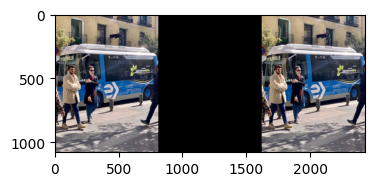

In [38]:
# 绘制
img_h, img_w = img.shape[0:2]
zeros = np.zeros((160,160,3), dtype=np.uint8)
begin_time = time()
for index in indices:
    score = scores[index]
    class_id = ids[index]
    x1, y1, x2, y2 = dbboxes[index]
    x1_corp, y1_corp, x2_corp, y2_corp = int(x1*x_scale_corp), int(y1*y_scale_corp), int(x2*x_scale_corp), int(y2*y_scale_corp)
    # mask
    mask = (np.sum(masks[index, :,:,:]*proto[:,y1_corp:y2_corp,x1_corp:x2_corp], axis=0) > 0.0).astype(np.int32)
    zeros[y1_corp:y2_corp,x1_corp:x2_corp, :][mask == 1] = yolo_colors[class_id%20]
    # bbox
    x1, y1, x2, y2 = int(x1*x_scale), int(y1*y_scale), int(x2*x_scale), int(y2*y_scale)
    # print("(%d, %d, %d, %d) -> %s: %.2f"%(x1,y1,x2,y2, coco_names[class_id], score))
    draw_detection(img, (x1, y1, x2, y2), score, class_id)
print("\033[0;31;40m" + "Draw Result time = %.2f ms"%(1000*(time() - begin_time)) + "\033[0m")

begin_time = time()
zeros = cv2.resize(zeros, (img_w, img_h),cv2.INTER_LANCZOS4)
result = np.clip(img + 0.5*zeros, 0, 255).astype(np.uint8)
print("\033[0;31;40m" + "Add Mask time = %.2f ms"%(1000*(time() - begin_time)) + "\033[0m")

jshow(np.hstack((img, zeros, result)))

In [ ]:
# 保存图片到本地
begin_time = time()
if img_h > img_w: # 横着
    cv2.imwrite(opt.test_img + ".result.png", np.hstack((img, zeros, result)))
else: # 竖着
    cv2.imwrite(opt.test_img + ".result.png", np.vstack((img, zeros, result)))
print("\033[0;31;40m" + "cv2.imwrite time = %.2f ms"%(1000*(time() - begin_time)) + "\033[0m")

In [1]:
x_scale_corp

NameError: name 'x_scale_corp' is not defined